<h4>CNN on cifar guidelines</h4>

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 200
l = 40
num_filter = 20
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)

        # Removing the dropout layer as per requirement.
        #if dropout_rate>0:
        #    Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)

        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)

    # Removing the dropout layer as per requirement.
    #if dropout_rate>0:
    #     Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    new_layer = layers.Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    output = Activation('softmax')(new_layer)
    flat = Flatten()(output)
    return flat

In [8]:
## increasing the number of filters
num_filter = 24

##Dropout is commenented. paramter doesnt affect anything
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

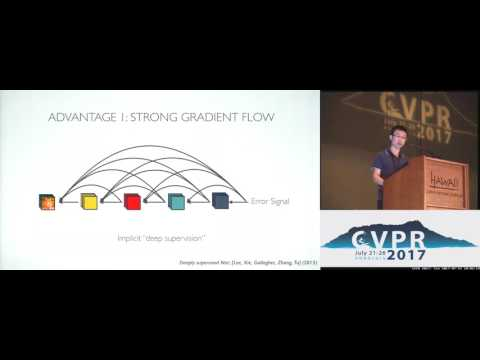

In [9]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
## Addition Image augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 15)
datagen.fit(X_train)

In [12]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])



In [13]:
## Train for first 50 epochs
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 50, validation_data =(X_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
391/390 [==============================] - 67s 173ms/step - loss: 1.5796 - accuracy: 0.4196 - val_loss: 2.3397 - val_accuracy: 0.3457
Epoch 2/50
391/390 [==============================] - 66s 169ms/step - loss: 1.2372 - accuracy: 0.5512 - val_loss: 1.7781 - val_accuracy: 0.4764
Epoch 3/50
391/390 [==============================] - 67s 171ms/step - loss: 1.0696 - accuracy: 0.6180 - val_loss: 1.1352 - val_accuracy: 0.6151
Epoch 4/50
391/390 [==============================] - 67s 172ms/step - loss: 0.9627 - accuracy: 0.6567 - val_loss: 1.0799 - val_accuracy: 0.6372
Epoch 5/50
391/390 [==============================] - 68s 173ms/step - loss: 0.8757 - accuracy: 0.6882 - val_loss: 0.8724 - val_accuracy: 0.6952
Epoch 6/50
391/390 [==============================] - 68s 173ms/step - loss: 0.8119 - accuracy: 0.7139 - val_loss: 1.3121 - val_accuracy: 0.6158
Epoch 7/50
391/390 [==============================] - 

In [14]:
# Test the model


model.evaluate(X_test, y_test)
 

313/313 [==============================] - 3s 11ms/step - loss: 0.4212 - accuracy: 0.8658


[0.4212377071380615, 0.8658000230789185]

In [15]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


 Adding 5 more epochs to get further accuracy

In [16]:
## Adding 5 more epochs
## 55  epochs total (50 +5)
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 5, validation_data =(X_test, y_test))

Epoch 1/5
391/390 [==============================] - 68s 173ms/step - loss: 0.2947 - accuracy: 0.8970 - val_loss: 0.4712 - val_accuracy: 0.8547
Epoch 2/5
391/390 [==============================] - 68s 173ms/step - loss: 0.2914 - accuracy: 0.8990 - val_loss: 0.3914 - val_accuracy: 0.8746
Epoch 3/5
391/390 [==============================] - 68s 173ms/step - loss: 0.2876 - accuracy: 0.9001 - val_loss: 0.4355 - val_accuracy: 0.8705
Epoch 4/5
391/390 [==============================] - 68s 173ms/step - loss: 0.2799 - accuracy: 0.9014 - val_loss: 0.4131 - val_accuracy: 0.8743
Epoch 5/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2817 - accuracy: 0.8995 - val_loss: 0.4418 - val_accuracy: 0.8626


In [17]:
# Test the model


model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.4418 - accuracy: 0.8626


[0.4417913556098938, 0.8626000285148621]

In [19]:
## Retrain for 5 epochs with reduced learning rate.
## Total 6o epochs
import keras
keras.backend.set_value(model.optimizer.lr, 0.005)

from keras.preprocessing.image import ImageDataGenerator

model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 5, validation_data =(X_test, y_test))

Epoch 1/5
391/390 [==============================] - 67s 170ms/step - loss: 0.2813 - accuracy: 0.9006 - val_loss: 0.3898 - val_accuracy: 0.8781
Epoch 2/5
391/390 [==============================] - 67s 171ms/step - loss: 0.2706 - accuracy: 0.9061 - val_loss: 0.4209 - val_accuracy: 0.8659
Epoch 3/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2722 - accuracy: 0.9045 - val_loss: 0.4547 - val_accuracy: 0.8563
Epoch 4/5
391/390 [==============================] - 67s 173ms/step - loss: 0.2733 - accuracy: 0.9039 - val_loss: 0.4036 - val_accuracy: 0.8702
Epoch 5/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2640 - accuracy: 0.9078 - val_loss: 0.5477 - val_accuracy: 0.8400


In [24]:
## Continue training with LR =0.005
## Total 65 epochs
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 5, validation_data =(X_test, y_test))

Epoch 1/5
391/390 [==============================] - 68s 173ms/step - loss: 0.2180 - accuracy: 0.9234 - val_loss: 0.4041 - val_accuracy: 0.8758
Epoch 2/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2168 - accuracy: 0.9242 - val_loss: 0.4466 - val_accuracy: 0.8702
Epoch 3/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2190 - accuracy: 0.9228 - val_loss: 0.4324 - val_accuracy: 0.8682
Epoch 4/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2114 - accuracy: 0.9252 - val_loss: 0.4716 - val_accuracy: 0.8629
Epoch 5/5
391/390 [==============================] - 67s 172ms/step - loss: 0.2121 - accuracy: 0.9268 - val_loss: 0.4457 - val_accuracy: 0.8681


In [25]:
## Retrain for 5 epochs with reduced learning rate.
## Total 70 epochs
keras.backend.set_value(model.optimizer.lr, 0.005)

from keras.preprocessing.image import ImageDataGenerator
 
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 5, validation_data =(X_test, y_test))

Epoch 1/5
391/390 [==============================] - 68s 173ms/step - loss: 0.4741 - accuracy: 0.8371 - val_loss: 0.7520 - val_accuracy: 0.7726
Epoch 2/5
391/390 [==============================] - 67s 172ms/step - loss: 0.4198 - accuracy: 0.8541 - val_loss: 0.5075 - val_accuracy: 0.8325
Epoch 3/5
391/390 [==============================] - 67s 173ms/step - loss: 0.4004 - accuracy: 0.8601 - val_loss: 0.6964 - val_accuracy: 0.7909
Epoch 4/5
391/390 [==============================] - 67s 172ms/step - loss: 0.3950 - accuracy: 0.8635 - val_loss: 0.6594 - val_accuracy: 0.8058
Epoch 5/5
391/390 [==============================] - 67s 172ms/step - loss: 0.3844 - accuracy: 0.8660 - val_loss: 0.8944 - val_accuracy: 0.7622


In [26]:
## Reducing learning rate and train for 10 more epochs
## Total 80 epochs
keras.backend.set_value(model.optimizer.lr, 0.002)

from keras.preprocessing.image import ImageDataGenerator
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 10, validation_data =(X_test, y_test))

Epoch 1/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2871 - accuracy: 0.9001 - val_loss: 0.3743 - val_accuracy: 0.8775
Epoch 2/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2688 - accuracy: 0.9057 - val_loss: 0.4853 - val_accuracy: 0.8507
Epoch 3/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2633 - accuracy: 0.9081 - val_loss: 0.5016 - val_accuracy: 0.8480
Epoch 4/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2596 - accuracy: 0.9098 - val_loss: 0.5207 - val_accuracy: 0.8515
Epoch 5/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2549 - accuracy: 0.9108 - val_loss: 0.4659 - val_accuracy: 0.8587
Epoch 6/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2518 - accuracy: 0.9104 - val_loss: 0.3625 - val_accuracy: 0.8875
Epoch 7/10
391/390 [==============================] - 67s 172ms/step - loss: 0.2448 - accuracy: 0.9152 - val_loss: 0.4731 - val_ac

In [27]:
## 10 more epochs with reduced LR
## Total 90 epochs
keras.backend.set_value(model.optimizer.lr, 0.001)

from keras.preprocessing.image import ImageDataGenerator
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 10, validation_data =(X_test, y_test))

Epoch 1/10
391/390 [==============================] - 68s 173ms/step - loss: 0.2014 - accuracy: 0.9296 - val_loss: 0.3146 - val_accuracy: 0.9045
Epoch 2/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1937 - accuracy: 0.9319 - val_loss: 0.3371 - val_accuracy: 0.8999
Epoch 3/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1899 - accuracy: 0.9333 - val_loss: 0.3308 - val_accuracy: 0.9020
Epoch 4/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1798 - accuracy: 0.9354 - val_loss: 0.3502 - val_accuracy: 0.8958
Epoch 5/10
391/390 [==============================] - 67s 173ms/step - loss: 0.1776 - accuracy: 0.9376 - val_loss: 0.4075 - val_accuracy: 0.8839
Epoch 6/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1817 - accuracy: 0.9356 - val_loss: 0.3264 - val_accuracy: 0.9025
Epoch 7/10
 91/390 [=====>........................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9388

KeyboardInterrupt: ignored

In [29]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_llr.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
# Test the model


model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.3419 - accuracy: 0.8997


[0.3418941795825958, 0.8996999859809875]

In [32]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 5, validation_data =(X_test, y_test))

Epoch 1/5
391/390 [==============================] - 68s 173ms/step - loss: 0.1749 - accuracy: 0.9384 - val_loss: 0.4608 - val_accuracy: 0.8750
Epoch 2/5
391/390 [==============================] - 67s 172ms/step - loss: 0.1701 - accuracy: 0.9389 - val_loss: 0.4087 - val_accuracy: 0.8853
Epoch 3/5
391/390 [==============================] - 67s 172ms/step - loss: 0.1715 - accuracy: 0.9396 - val_loss: 0.4030 - val_accuracy: 0.8880
Epoch 4/5
391/390 [==============================] - 67s 172ms/step - loss: 0.1705 - accuracy: 0.9389 - val_loss: 0.4171 - val_accuracy: 0.8865
Epoch 5/5
391/390 [==============================] - 67s 173ms/step - loss: 0.1680 - accuracy: 0.9418 - val_loss: 0.3939 - val_accuracy: 0.8875


In [33]:
model.fit_generator(datagen.flow(X_train, y_train, batch_size), steps_per_epoch = X_train.shape[0]/batch_size, epochs = 10, validation_data =(X_test, y_test))

Epoch 1/10
391/390 [==============================] - 68s 174ms/step - loss: 0.1652 - accuracy: 0.9416 - val_loss: 0.3597 - val_accuracy: 0.8971
Epoch 2/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1629 - accuracy: 0.9422 - val_loss: 0.3764 - val_accuracy: 0.8928
Epoch 3/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1616 - accuracy: 0.9430 - val_loss: 0.3448 - val_accuracy: 0.9000
Epoch 4/10
391/390 [==============================] - 67s 172ms/step - loss: 0.1637 - accuracy: 0.9424 - val_loss: 0.4323 - val_accuracy: 0.8834
Epoch 5/10
391/390 [==============================] - 68s 173ms/step - loss: 0.1616 - accuracy: 0.9430 - val_loss: 0.3469 - val_accuracy: 0.9017
Epoch 6/10
391/390 [==============================] - 68s 173ms/step - loss: 0.1558 - accuracy: 0.9439 - val_loss: 0.3130 - val_accuracy: 0.9097
Epoch 7/10
391/390 [==============================] - 68s 173ms/step - loss: 0.1554 - accuracy: 0.9451 - val_loss: 0.4083 - val_ac